# Import Standard Libraries & Custom Functions

In [3]:
# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   

# Load data

In [4]:
## url
url_train = 'https://github.com/PsyCapsLock/PubBiasDetect/blob/main/Data/Train_Test_Dev/train_2023-07-26.csv?raw=true'
url_dev = 'https://github.com/PsyCapsLock/PubBiasDetect/blob/main/Data/Train_Test_Dev/dev_2023-07-26.csv?raw=true'
url_test = 'https://github.com/PsyCapsLock/PubBiasDetect/blob/main/Data/Train_Test_Dev/test_2023-07-26.csv?raw=true'
url_val1 = 'https://github.com/PsyCapsLock/PubBiasDetect/blob/main/Data/Validation/validation_1_nongerman_2023-07-28.csv?raw=true'
url_val2 = 'https://github.com/PsyCapsLock/PubBiasDetect/blob/main/Data/Validation/validation_2_1990-2012_2023-07-28.csv?raw=true'


## Load data
df_train=pd.concat([pd.read_csv(url_train), pd.read_csv(url_dev)])
df_test = pd.read_csv(url_test)

df_val1=pd.read_csv(url_val1)
df_val2=pd.read_csv(url_val2)


In [ ]:
from nltk.corpus import wordnet
from nltk import pos_tag
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(treebank_tag):
    """Map Treebank pos tags to WordNet pos tags"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # Default to noun if the pos tag doesn't start with J, V, N, or R
        return wordnet.NOUN


def preprocess(X):
    documents = []
    lemmatizer = WordNetLemmatizer()

    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X.iloc[sen]))

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        # Tokenization and POS tagging
        tokens = word_tokenize(document)
        tagged_tokens = pos_tag(tokens)
        document = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens])

        documents.append(document)
        
    return documents


# Stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
no_stop = ["no", "not", "nor"]
stopwords_start = stopwords.words('english')
stopwords_adjusted = [item for item in stopwords_start if item not in no_stop]


# paste and list
def paste_and_list(path_x, pattern_x):
    files = [f for f in os.listdir(path_x) if os.path.isfile(os.path.join(path_x, f)) and pattern_x in f]
    pasted_path = [os.path.join(path_x, f) for f in files]
    pasted_path = re.sub(r"\\", "/", pasted_path[0])
    return pasted_path

### Preprocess

In [6]:
## Preprocess
df_train["text"]=preprocess(df_train["text"])
df_test["text"]=preprocess(df_test["text"])

## show data
df_train.head(5)
df_test.head(5)

,text,label
0,background to date cultural clinical research ...,1.0
1,anticipate population age to reach a historica...,1.0
2,objective deficit in explicit learning and mem...,0.0
3,abstract background previous laboratory findin...,0.0
4,suppress unwanted memory can impair their late...,1.0


### Create Train and Test Vectors

In [7]:
X_train = df_train["text"]
y_train = df_train["label"]
X_test = df_test["text"] 
y_test = df_test["label"]

# Pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state = 42)),
 ])

### Hyperparameter tuning


In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 3000, num = 3)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 32, num = 5)]
max_depth.append(None)

# Create the random grid
random_grid = {'vect__max_features':        [500,1500, 2000],           #   3 Values
               'vect__stop_words':          [None,stopwords_adjusted],  #   2 Values
               'vect__ngram_range':         [(1,2),(1,3)],              #   2 Values
               'clf__n_estimators':         n_estimators,               #   3 Values
               'clf__max_features':         ['auto', 'sqrt'],           #   2 Values
               'clf__max_depth':            max_depth,                  #   6 Values
               'clf__min_samples_split':    [2, 5],                     #   2 Values
               'clf__min_samples_leaf':     [1, 2, 4],                  #   3 Values
               'clf__bootstrap':            [True, False]}              #   2 Values
print(random_grid)

{'vect__max_features': [500, 1500, 2000], 'vect__stop_words': [None, ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some

In [10]:
import os
from sklearn.model_selection import RandomizedSearchCV
from datetime import date
import pickle

# Specify the filename
pkl_filename = f"Hyperparameters/best_rf_2023-07-27.pkl"

# Check if a hyperparameter file exists in the hyperparameter folder
if not os.path.exists(paste_and_list('Hyperparameters', 'best_rf_')):
    # If the file doesn't exist, fit the model and save it to a file
    rf_random = RandomizedSearchCV(estimator = text_clf,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = 5,
                                   verbose=10,
                                   random_state=42,
                                   n_jobs = -1)
    rf_random.fit(X_train, y_train)

    # Get the best estimator from RandomizedSearchCV
    best_model = rf_random.best_estimator_

    # Save to file in the current working directory
    with open(pkl_filename, 'wb') as file:
        pickle.dump(best_model, file)
else:
    # If the file exists, load the model from the file
    with open(pkl_filename, 'rb') as file:
        best_model = pickle.load(file)

In [11]:
print(best_model)

Pipeline(steps=[('vect',
                 CountVectorizer(max_features=2000, ngram_range=(1, 2))),
                ('clf',
                 RandomForestClassifier(max_depth=32, max_features='auto',
                                        min_samples_leaf=2, n_estimators=1000,
                                        random_state=42))])


# Results

### Confusion Matrix & Classification Report

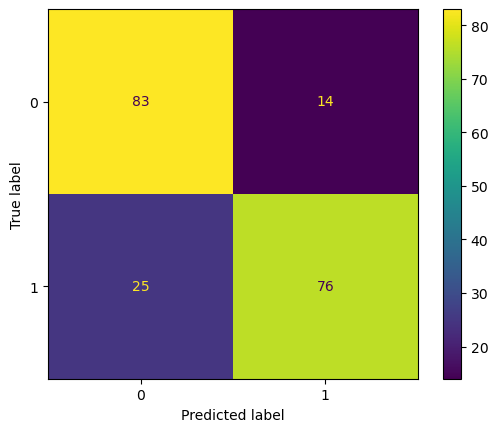

              precision    recall  f1-score   support

         0.0      0.769     0.856     0.810        97
         1.0      0.844     0.752     0.796       101

    accuracy                          0.803       198
   macro avg      0.806     0.804     0.803       198
weighted avg      0.807     0.803     0.803       198

0.803030303030303


In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# classifcation report & accuracy
print(classification_report(y_test,y_pred,digits=3))
print(accuracy_score(y_test, y_pred))

In [13]:
df_val1["text"]=preprocess(df_val1["text"])
df_val2["text"]=preprocess(df_val2["text"])

X_val1 = df_val1["text"]
y_val1 = df_val1["label"]
X_val2 = df_val2["text"]
y_val2 = df_val2["label"]

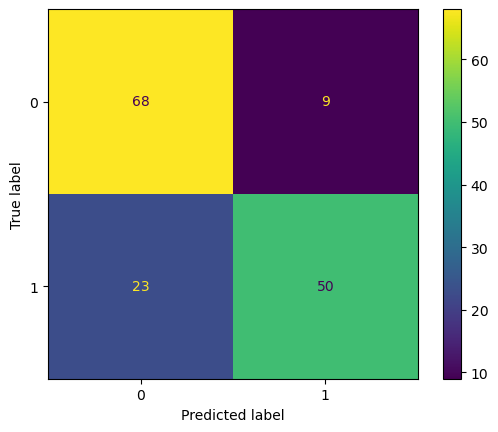

              precision    recall  f1-score   support

           0      0.747     0.883     0.810        77
           1      0.847     0.685     0.758        73

    accuracy                          0.787       150
   macro avg      0.797     0.784     0.784       150
weighted avg      0.796     0.787     0.784       150

0.7866666666666666


In [14]:
# Make predictions on the validation set 1

# validation 1
y_pred_val1 = best_model.predict(X_val1)

cm = confusion_matrix(y_val1, y_pred_val1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# classifcation report & accuracy
print(classification_report(y_val1,y_pred_val1,digits=3))
print(accuracy_score(y_val1, y_pred_val1))

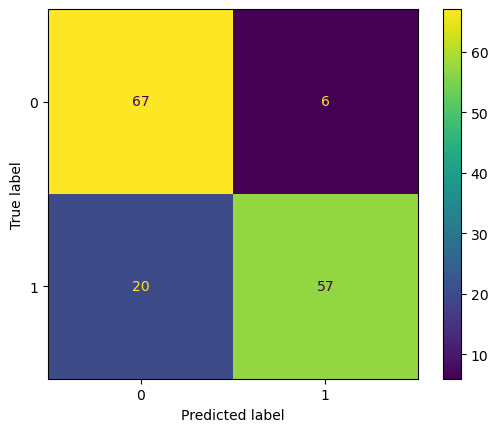

              precision    recall  f1-score   support

           0      0.770     0.918     0.838        73
           1      0.905     0.740     0.814        77

    accuracy                          0.827       150
   macro avg      0.837     0.829     0.826       150
weighted avg      0.839     0.827     0.826       150

0.8266666666666667


In [15]:
# Make predictions on the validation set 2

# validation 2
y_pred_val2 = best_model.predict(X_val2)

cm = confusion_matrix(y_val2, y_pred_val2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# classifcation report & accuracy
print(classification_report(y_val2,y_pred_val2,digits=3))
print(accuracy_score(y_val2, y_pred_val2))

### Plot Feature Importance

                importance
do not            0.032744
do                0.026724
no                0.026335
but not           0.019687
be not            0.018081
but               0.017203
not differ        0.009031
no significant    0.007464
be no             0.005617
no difference     0.005063
however           0.004969
nor               0.004958
be                0.004717
difference        0.004647
the               0.004533
of                0.004413
differ            0.004413
and               0.004300
in                0.004001


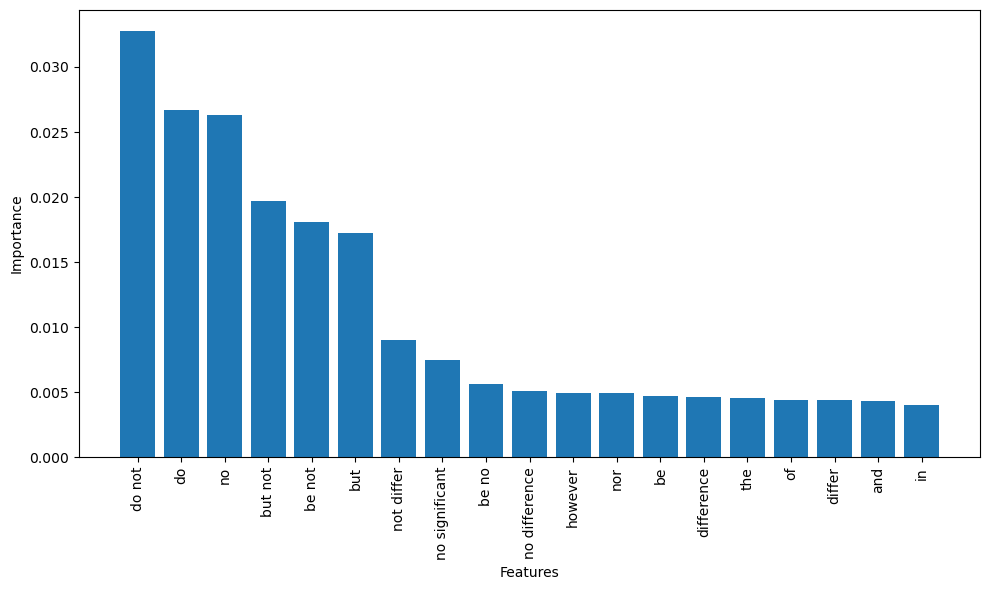

In [16]:
feat_names=best_model[:-1].get_feature_names_out()
importances = pd.DataFrame(data=best_model.steps[1][1].feature_importances_, index=feat_names)
importances=importances.rename(columns={0: "importance"})

# Sort the feature importances in descending order
importances = importances.sort_values(by="importance", ascending=False)

# Print the feature importances
print(importances.iloc[1:20,:])

importances20=importances.iloc[1:20,:]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importances20.index, importances20['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()